In [75]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import requests
import numpy as np
import folium
from folium import IFrame
import xml.etree.ElementTree as ET
from scipy.spatial.distance import cdist
from fuzzywuzzy import process
import seaborn as sns

Load the Encounters_csv

In [76]:
encounters_df = pd.read_csv('/Users/brandoncooke/Public/NEW REP SPACE/US_Southern_Border_Metrics/Data/DATA FOR BORDER MAP/nationwide-encounters-fy21-fy24-mar-aor.csv')

# Group by 'Area of Responsibility', 'Fiscal Year', 'Citizenship', 'Title of Authority', and 'Encounter Type', then sum the 'Encounter Count'
encounter_type_totals = encounters_df.groupby(['Area of Responsibility', 'Fiscal Year', 'Citizenship', 'Title of Authority', 'Encounter Type'])['Encounter Count'].sum().reset_index()
encounter_type_totals
encounter_type_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Area of Responsibility  3860 non-null   object
 1   Fiscal Year             3860 non-null   object
 2   Citizenship             3860 non-null   object
 3   Title of Authority      3860 non-null   object
 4   Encounter Type          3860 non-null   object
 5   Encounter Count         3860 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 181.1+ KB


In [77]:
encounter_type_totals.describe()
encounter_type_totals.head(10)

,Area of Responsibility,Fiscal Year,Citizenship,Title of Authority,Encounter Type,Encounter Count
0,Atlanta Field Office,2021,BRAZIL,Title 8,Inadmissibles,23
1,Atlanta Field Office,2021,CANADA,Title 8,Inadmissibles,74
2,Atlanta Field Office,2021,"CHINA, PEOPLES REPUBLIC OF",Title 8,Inadmissibles,2006
3,Atlanta Field Office,2021,COLOMBIA,Title 8,Inadmissibles,405
4,Atlanta Field Office,2021,CUBA,Title 8,Inadmissibles,53
5,Atlanta Field Office,2021,ECUADOR,Title 8,Inadmissibles,30
6,Atlanta Field Office,2021,EL SALVADOR,Title 8,Inadmissibles,30
7,Atlanta Field Office,2021,GUATEMALA,Title 8,Inadmissibles,66
8,Atlanta Field Office,2021,HAITI,Title 8,Inadmissibles,5
9,Atlanta Field Office,2021,HONDURAS,Title 8,Inadmissibles,76


Load the Border map that Plots the Border GEOJSON file to show the Border of the Southern United States along with points for Border Patrol Checkpoints

In [78]:
# Load the border patrol stations data
with open('/Users/brandoncooke/Public/NEW REP SPACE/US_Southern_Border_Metrics/Data/DATA FOR BORDER MAP/doc.kml', 'rb') as file:
    root = ET.fromstring(file.read())

points = []
for placemark in root.findall('.//{http://earth.google.com/kml/2.1}Placemark'):
    name = placemark.find('{http://earth.google.com/kml/2.1}name').text
    coordinates = placemark.find('.//{http://earth.google.com/kml/2.1}coordinates').text.split(',')
    latitude = float(coordinates[1])
    longitude = float(coordinates[0])
    points.append({'name': name, 'latitude': latitude, 'longitude': longitude})

points_df = pd.DataFrame(points)

#points_df['Mapped Location'] = ''

points_df

,name,latitude,longitude
0,San Clementes Checkpoint,33.352500,-117.525556
1,Temecula Checkpoint,33.446944,-117.134722
2,I-8 West Checkpoint,32.797222,-116.496389
3,Highway 94 Checkpoint,32.664167,-116.818611
4,Highway 78/86 Checkpoint,33.125000,-115.854722
5,Highway 111 Checkpoint,33.360278,-115.644722
6,#7,33.259464,14.243200
7,Yuma Checkpoint,32.659722,-114.363889
8,Why Checkpoint,32.202500,-112.759167
9,Gila Bend Checkpoint,32.714722,-112.841944


Creating a API pull from google maps to try and link sector names to Coords, and then using it to plot on my folium map!
You will need your own API key to generate access to the google mapping API

Also Manually entering in Geos for Rio Grande Valley Sector

In [79]:
# Define the areas of responsibility as a list of dictionaries to obtain coordinates for the map
areas_of_responsibility = [
    {'name': 'El Paso Field Office'},
    {'name': 'El Paso Sector'},
    {'name': 'Laredo Field Office'},
    {'name': 'Laredo Sector'},
    {'name': 'Rio Grande Valley Sector'},
    {'name': 'San Diego Field Office'},
    {'name': 'San Diego Sector'},
    {'name': 'Tucson Field Office'},
    {'name': 'Tucson Sector'}
]

# Modify the get_coordinates function to handle None values
def get_coordinates(location):
    api_key = 'YOUR_API_KEY'  # Replace 'YOUR_API_KEY' with your actual API key
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {
        'address': location,
        'key': api_key
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    if data['status'] == 'OK':
        lat = data['results'][0]['geometry']['location']['lat']
        lng = data['results'][0]['geometry']['location']['lng']
        return lat, lng
    else:
        print(f"No coordinates found for {location}.")
        return None

# Get the coordinates for each area of responsibility
for area in areas_of_responsibility:
    coords = get_coordinates(area['name'])
    if coords is not None:
        area['latitude'], area['longitude'] = coords
    else:
        print(f"No coordinates found for {area['name']}.")


filtered_areas = [area for area in areas_of_responsibility if 'latitude' in area and 'longitude' in area]

coordinates_df = pd.DataFrame(filtered_areas)

# Check if "Rio Grande Valley Sector" is present in coordinates_df
is_present = 'Rio Grande Valley Sector' in coordinates_df['name'].values

if not is_present:
    rio_grande_valley = {'name': 'Rio Grande Valley Sector', 'latitude': 26.260361, 'longitude': -98.166618}
    coordinates_df = pd.concat([coordinates_df, pd.DataFrame([rio_grande_valley])], ignore_index=True)

# Now, re-run the merging code to ensure "Rio Grande Valley Sector" is included
merged_df = pd.merge(coordinates_df, encounter_type_totals, left_on='name', right_on='Area of Responsibility', how='left')

# Check if "Rio Grande Valley Sector" is in the DataFrame
is_present = 'Rio Grande Valley Sector' in merged_df['name'].values

# Print
print("Rio Grande Valley Sector is present:", is_present)


No coordinates found for El Paso Field Office.
No coordinates found for El Paso Field Office.
No coordinates found for Rio Grande Valley Sector.
No coordinates found for Rio Grande Valley Sector.
Rio Grande Valley Sector is present: True


In [80]:
merged_df

,name,latitude,longitude,Area of Responsibility,Fiscal Year,Citizenship,Title of Authority,Encounter Type,Encounter Count
0,El Paso Sector,31.761878,-106.485022,El Paso Sector,2021,BRAZIL,Title 42,Expulsions,1672
1,El Paso Sector,31.761878,-106.485022,El Paso Sector,2021,BRAZIL,Title 8,Apprehensions,469
2,El Paso Sector,31.761878,-106.485022,El Paso Sector,2021,COLOMBIA,Title 42,Expulsions,712
3,El Paso Sector,31.761878,-106.485022,El Paso Sector,2021,COLOMBIA,Title 8,Apprehensions,62
4,El Paso Sector,31.761878,-106.485022,El Paso Sector,2021,CUBA,Title 42,Expulsions,5117
...,...,...,...,...,...,...,...,...,...
994,Rio Grande Valley Sector,26.260361,-98.166618,Rio Grande Valley Sector,2024 (FYTD),ROMANIA,Title 8,Apprehensions,19
995,Rio Grande Valley Sector,26.260361,-98.166618,Rio Grande Valley Sector,2024 (FYTD),RUSSIA,Title 8,Apprehensions,2
996,Rio Grande Valley Sector,26.260361,-98.166618,Rio Grande Valley Sector,2024 (FYTD),TURKEY,Title 8,Apprehensions,2
997,Rio Grande Valley Sector,26.260361,-98.166618,Rio Grande Valley Sector,2024 (FYTD),UKRAINE,Title 8,Apprehensions,1


Creating a Folium map showing all US Southern Border Sectors and Checkpoints.

In [86]:
# Create a Folium map centered on the border coordinates
map = folium.Map(location=[border_geojson_data['features'][0]['geometry']['coordinates'][0][1], border_geojson_data['features'][0]['geometry']['coordinates'][0][0]], zoom_start=10)
merged_df['Encounter Type'] = merged_df['Encounter Type'].astype('category')
merged_df['Title of Authority'] = merged_df['Title of Authority'].astype('category')

# Add the border as a GeoJSON layer
folium.GeoJson(border_geojson_data).add_to(map)

def calculate_sums_based_on_year(data, year):
    year_data = data[data['Fiscal Year'] == year]
    sum_encounter_count = year_data['Encounter Count'].sum()
    most_seen_citizenship = year_data['Citizenship'].value_counts().idxmax() if not year_data['Citizenship'].isnull().all() else None
    most_seen_encounter_type = year_data['Encounter Type'].value_counts().idxmax() if not year_data['Encounter Type'].isnull().all() else None
    most_seen_title_of_authority = year_data['Title of Authority'].value_counts().idxmax() if not year_data['Title of Authority'].isnull().all() else None
    return sum_encounter_count, most_seen_citizenship, most_seen_encounter_type, most_seen_title_of_authority

for area in merged_df['Area of Responsibility'].unique():
    area_data = merged_df[merged_df['Area of Responsibility'] == area]
    sum_encounter_count, most_seen_citizenship, most_seen_encounter_type, most_seen_title_of_authority = calculate_sums_based_on_year(area_data, '2023')
    popup_message = f"<b>Border Patrol Sector:</b> {area}<br>"
    popup_message += f"<b>Total Apprehensions:</b> {sum_encounter_count}<br>"
    popup_message += f"<b>Most Seen Citizenship:</b> {most_seen_citizenship}<br>"
    popup_message += f"<b>Most Seen Encounter Type:</b> {most_seen_encounter_type}<br>"
    popup_message += f"<b>Most Seen Title of Authority:</b> {most_seen_title_of_authority}<br>"
    folium.Marker(location=[area_data.iloc[0]['latitude'], area_data.iloc[0]['longitude']], popup=popup_message, icon=folium.Icon(color='red', icon='cloud', prefix='fa')).add_to(map)

# Add markers for each checkpoint
for index, row in points_df.iterrows():
    popup_message = f"<b>Name:</b> {row['name']}<br>"
    popup_message += f"<b>Latitude:</b> {row['latitude']}<br>"
    popup_message += f"<b>Longitude:</b> {row['longitude']}<br>"
    folium.Marker(location=[row['latitude'], row['longitude']], popup=popup_message).add_to(map)


# Add layer control
folium.LayerControl().add_to(map)

map.save("Best_border_map.html")

# Display the map
map


Calculating the length of the US Southern Border.

In [82]:
border_data = gpd.read_file('Data/DATA FOR BORDER MAP/border-fence.geojson')

# Calculate total length of the border line segments
total_length = border_data.geometry.length.sum()

# Calculate number of vertices
num_vertices = border_data.geometry.apply(lambda x: len(x.coords)).sum()

# Create a single polygon representing the entire border
border_polygon = border_data.geometry.unary_union

# Calculate convex hull area
convex_hull_area = border_polygon.convex_hull.area

print("Total border length:", total_length)
print("Number of vertices:", num_vertices)
print("Convex hull area:", convex_hull_area);

DriverError: Data/DATA FOR BORDER MAP/border-fence.geojson: No such file or directory

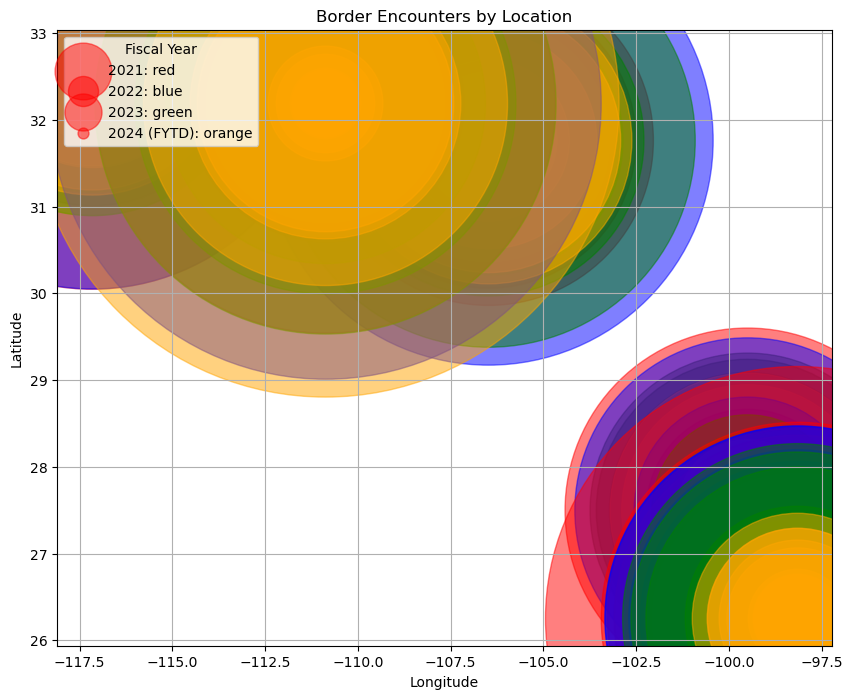

In [ ]:
filtered_data = merged_df  # Filtered data based on your requirements

# Define marker colors or styles based on different categories
# For example, you can create a dictionary mapping each category to a color or marker style
color_map = {'2021': 'red', '2022': 'blue', '2023': 'green', '2024 (FYTD)': 'orange'}  # Example for Fiscal Year, modify as needed

# Create the scatter plot
plt.figure(figsize=(10, 8))
for index, row in filtered_data.iterrows():
    plt.scatter(row['longitude'], row['latitude'], s=row['Encounter Count'], c=color_map[row['Fiscal Year']], alpha=0.5)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Border Encounters by Location')
legend_labels = [f"{year}: {color}" for year, color in color_map.items()]
plt.legend(title='Fiscal Year', labels=legend_labels, loc='upper left')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from scipy.spatial import distance

# Assuming you have latitude and longitude values for each encounter stored in lists or arrays
# If you have these values stored differently, adjust accordingly

# Example latitude and longitude values (replace these with your actual data)
latitude_values = [51259]  # Example latitude values
longitude_values = [51259]  # Example longitude values

# Add latitude and longitude columns to encounters_df
encounters_df['latitude'] = latitude_values
encounters_df['longitude'] = longitude_values


# Define a function to find the nearest checkpoint for each encounter
def find_nearest_checkpoint(encounter_row, points_df):
    encounter_coords = (encounter_row['latitude'], encounter_row['longitude'])
    min_distance = float('inf')
    nearest_checkpoint = None
    for index, checkpoint_row in points_df.iterrows():
        checkpoint_coords = (checkpoint_row['latitude'], checkpoint_row['longitude'])
        dist = distance.euclidean(encounter_coords, checkpoint_coords)
        if dist < min_distance:
            min_distance = dist
            nearest_checkpoint = checkpoint_row['name']
    return nearest_checkpoint

# Apply the function to each row in encounters_df
encounters_df['nearest_checkpoint'] = encounters_df.apply(lambda row: find_nearest_checkpoint(row, points_df), axis=1)

# Now encounters_df has a new column 'nearest_checkpoint' with the name of the nearest checkpoint for each encounter


ValueError: Length of values (1) does not match length of index (51259)